In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import keras.utils as image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import optuna
from efficientnet_v2 import EfficientNetV2B0
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from efficientnet_v2 import EfficientNetV2B0
from optuna.trial import TrialState
%matplotlib inline

In [2]:
train = pd.read_csv('label4.csv', sep=';')    # reading the csv file
train.head()      # printing first five rows of the file

,image_name,almond,apple,asparagus,avocado,banana,beef,bellpepper,blueberry,bread,...,scallop,shrimp,spinach,squid,strawberry,sweetpotato,tuna,turmeric,vegetableoil,watermelon
0,almond (1).jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,almond (10).jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,almond (100).jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,almond (11).jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,almond (12).jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.columns

Index(['image_name', 'almond', 'apple', 'asparagus', 'avocado', 'banana',
       'beef', 'bellpepper', 'blueberry', 'bread', 'broccoli', 'butter',
       'cabbage', 'carrot', 'cashew', 'cauliflower', 'cheese', 'chicken',
       'chili', 'chocolate', 'cinnamon', 'coconut', 'cod', 'corn', 'crab',
       'cucumber', 'dragonfruit', 'egg', 'garlic', 'ginger', 'greenbean',
       'greenonion', 'honey', 'lettuce', 'lobster', 'mango', 'melon', 'milk',
       'mushroom', 'noodles', 'octopus', 'onion', 'orange', 'pasta', 'peanut',
       'pear', 'pineapple', 'potato', 'redpepperflake', 'rice', 'salmon',
       'scallop', 'shrimp', 'spinach', 'squid', 'strawberry', 'sweetpotato',
       'tuna', 'turmeric', 'vegetableoil', 'watermelon'],
      dtype='object')

In [4]:
def histogram_equalize(img):
    b, g, r = cv2.split(img)                    #split image into bgr channels (blue, green, red - this is the default order for function cv2.split)
    red = cv2.equalizeHist(r)                   #carry out histogram equalizaton for each channel
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))        #merge back the three channels

def grey_world(img):
    alpha , beta, gamma = 1,1,1

    b, g, r = cv2.split(img)                    # split into red green and blue channels
    sumB = np.sum(b)
    sumG = np.sum(g)
    sumR = np.sum(r)
    n = np.ma.size(b)                           # no of elements - will be same for all channels

    #calculate averages
    avgB = (sumB/n)
    avgG = (sumG/n)
    avgR = (sumR/n)

    scale = float((avgB + avgG + avgR))/3.0

    denB = float(avgB) * gamma
    denG = float(avgG) * beta
    denR = float(avgR) * alpha

    blue = np.divide((np.multiply(b,scale)), denB)
    green = np.divide((np.multiply(g,scale)), denG)
    red = np.divide((np.multiply(r,scale)), denR)

    blue = np.array(blue, dtype= np.uint8)
    green = np.array(green, dtype= np.uint8)
    red = np.array(red, dtype= np.uint8)

    merged = cv2.merge((blue,green,red))
    return merged

In [5]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = cv2.resize(cv2.imread('RAW61_BW/'+train['image_name'][i]), (224,224))
    Img_hist = histogram_equalize(img)
    img = image.img_to_array(Img_hist)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:58<00:00, 102.82it/s]


In [6]:
X.shape

(6000, 224, 224, 3)

In [7]:
y = np.array(train.drop(['image_name'],axis=1))
y.shape

(6000, 60)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [9]:
# Without automated hyperparameter optimization
def build_model(num_classes=60):
    base_model = EfficientNetV2B0(
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k-ft1k" # Use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )

    base_model.trainable=False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(100, activation='relu')
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [46]:
# Without automated hyperparameter optimization 2 (different method)
def build_model():
    base_model = EfficientNetV2B0(
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k-ft1k" # Use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )

    base_model.trainable=False
    num_classes=60
    
    model = tf.keras.Sequential(base_model)
    model.add(tf.keras.layers.Dense(350, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.262882219302666))
    model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))
    
    return model

In [9]:
# Automated hyperparameter optimization for number of layers, neurons per layer, weight decay, and learning rate
def objective(trial):
    base_model = EfficientNetV2B0(
        input_shape=(224, 224, 3),
        include_top=False,
        pooling="avg",
        weights="imagenet-21k-ft1k" # Use pretrained on imagenet 21k and fine tuned on 1k weight variant.
    )

    base_model.trainable=False
    num_classes=60
    
    # Some hyperparameters to optimize
    # Dropout rate
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    # Neurons per layer
    n_units = trial.suggest_int('n_units', 64, 512)
    # Learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)

    model = tf.keras.Sequential(base_model)
    model.add(tf.keras.layers.Dense(n_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32)
    res = model.get_metrics_result()
    loss = res['loss'].numpy()    
        
    return loss

In [45]:
# Trial search for hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

trial = study.best_trial

print("Best trial loss: ", trial.value)

print("Best Parameters: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-15 15:19:36,216] A new study created in memory with name: no-name-1a9c753d-7e97-4d74-8254-c160e8c3de5f


169/169 [==============================] - 136s 775ms/step - loss: 0.0968 - accuracy: 0.2344 - val_loss: 0.0496 - val_accuracy: 0.5167


[I 2023-10-15 15:21:54,260] Trial 0 finished with value: 0.04957713186740875 and parameters: {'dropout': 0.4672180008143853, 'n_units': 260, 'learning_rate': 0.007775341968601526}. Best is trial 0 with value: 0.04957713186740875.


169/169 [==============================] - 142s 809ms/step - loss: 0.1333 - accuracy: 0.0533 - val_loss: 0.0801 - val_accuracy: 0.1583


[I 2023-10-15 15:24:18,336] Trial 1 finished with value: 0.08005798608064651 and parameters: {'dropout': 0.4032611053614288, 'n_units': 64, 'learning_rate': 0.009202800604611264}. Best is trial 0 with value: 0.04957713186740875.


169/169 [==============================] - 136s 776ms/step - loss: 0.0928 - accuracy: 0.2828 - val_loss: 0.0474 - val_accuracy: 0.5283


[I 2023-10-15 15:26:36,044] Trial 2 finished with value: 0.04735618457198143 and parameters: {'dropout': 0.48003700518782694, 'n_units': 417, 'learning_rate': 0.006480229771309693}. Best is trial 2 with value: 0.04735618457198143.


169/169 [==============================] - 136s 779ms/step - loss: 0.1003 - accuracy: 0.2207 - val_loss: 0.0596 - val_accuracy: 0.4467


[I 2023-10-15 15:28:54,204] Trial 3 finished with value: 0.05955241993069649 and parameters: {'dropout': 0.4176871046292, 'n_units': 281, 'learning_rate': 0.009835691956642178}. Best is trial 2 with value: 0.04735618457198143.


169/169 [==============================] - 145s 825ms/step - loss: 0.0945 - accuracy: 0.2243 - val_loss: 0.0541 - val_accuracy: 0.4917


[I 2023-10-15 15:31:21,711] Trial 4 finished with value: 0.054118964821100235 and parameters: {'dropout': 0.3926011832879633, 'n_units': 175, 'learning_rate': 0.00792022078375721}. Best is trial 2 with value: 0.04735618457198143.


169/169 [==============================] - 134s 762ms/step - loss: 0.0782 - accuracy: 0.3522 - val_loss: 0.0447 - val_accuracy: 0.5650


[I 2023-10-15 15:33:37,491] Trial 5 finished with value: 0.04466475546360016 and parameters: {'dropout': 0.26192741919169515, 'n_units': 280, 'learning_rate': 0.0066054888702311385}. Best is trial 5 with value: 0.04466475546360016.


169/169 [==============================] - 136s 779ms/step - loss: 0.0996 - accuracy: 0.2376 - val_loss: 0.0522 - val_accuracy: 0.5017


[I 2023-10-15 15:35:55,666] Trial 6 finished with value: 0.05220753699541092 and parameters: {'dropout': 0.43489453646667825, 'n_units': 318, 'learning_rate': 0.009424404363594926}. Best is trial 5 with value: 0.04466475546360016.


169/169 [==============================] - 153s 875ms/step - loss: 0.1205 - accuracy: 0.1150 - val_loss: 0.0578 - val_accuracy: 0.4950


[I 2023-10-15 15:38:31,450] Trial 7 finished with value: 0.05780121311545372 and parameters: {'dropout': 0.38128913748720084, 'n_units': 284, 'learning_rate': 0.0005459927317268993}. Best is trial 5 with value: 0.04466475546360016.


169/169 [==============================] - 146s 838ms/step - loss: 0.1202 - accuracy: 0.1259 - val_loss: 0.0581 - val_accuracy: 0.4817


[I 2023-10-15 15:40:59,684] Trial 8 finished with value: 0.05813845992088318 and parameters: {'dropout': 0.308812945344204, 'n_units': 79, 'learning_rate': 0.002100884616126921}. Best is trial 5 with value: 0.04466475546360016.


169/169 [==============================] - 153s 878ms/step - loss: 0.0934 - accuracy: 0.2483 - val_loss: 0.0520 - val_accuracy: 0.4800


[I 2023-10-15 15:43:34,633] Trial 9 finished with value: 0.051957208663225174 and parameters: {'dropout': 0.293140062931521, 'n_units': 174, 'learning_rate': 0.009316950900178502}. Best is trial 5 with value: 0.04466475546360016.


169/169 [==============================] - 172s 988ms/step - loss: 0.0749 - accuracy: 0.4087 - val_loss: 0.0417 - val_accuracy: 0.5633


[I 2023-10-15 15:46:29,590] Trial 10 finished with value: 0.04168061167001724 and parameters: {'dropout': 0.20845908114189432, 'n_units': 472, 'learning_rate': 0.004648780830779818}. Best is trial 10 with value: 0.04168061167001724.


169/169 [==============================] - 159s 906ms/step - loss: 0.0730 - accuracy: 0.4172 - val_loss: 0.0409 - val_accuracy: 0.5900


[I 2023-10-15 15:49:10,536] Trial 11 finished with value: 0.04086514934897423 and parameters: {'dropout': 0.21191446026138727, 'n_units': 499, 'learning_rate': 0.0048319856336587}. Best is trial 11 with value: 0.04086514934897423.


169/169 [==============================] - 160s 919ms/step - loss: 0.0709 - accuracy: 0.4122 - val_loss: 0.0419 - val_accuracy: 0.5883


[I 2023-10-15 15:51:52,543] Trial 12 finished with value: 0.041867394000291824 and parameters: {'dropout': 0.20720881171921499, 'n_units': 512, 'learning_rate': 0.0040836759696315636}. Best is trial 11 with value: 0.04086514934897423.


169/169 [==============================] - 156s 893ms/step - loss: 0.0717 - accuracy: 0.4196 - val_loss: 0.0404 - val_accuracy: 0.6050


[I 2023-10-15 15:54:31,437] Trial 13 finished with value: 0.04039309546351433 and parameters: {'dropout': 0.21524595307338826, 'n_units': 490, 'learning_rate': 0.004645767557586775}. Best is trial 13 with value: 0.04039309546351433.


169/169 [==============================] - 156s 888ms/step - loss: 0.0710 - accuracy: 0.4039 - val_loss: 0.0396 - val_accuracy: 0.6033


[I 2023-10-15 15:57:09,604] Trial 14 finished with value: 0.039567530155181885 and parameters: {'dropout': 0.2396740504849495, 'n_units': 405, 'learning_rate': 0.0038183529799722974}. Best is trial 14 with value: 0.039567530155181885.


169/169 [==============================] - 158s 902ms/step - loss: 0.0717 - accuracy: 0.4002 - val_loss: 0.0403 - val_accuracy: 0.5933


[I 2023-10-15 15:59:49,516] Trial 15 finished with value: 0.040303878486156464 and parameters: {'dropout': 0.2432508912066619, 'n_units': 392, 'learning_rate': 0.0033596821778405744}. Best is trial 14 with value: 0.039567530155181885.


169/169 [==============================] - 151s 854ms/step - loss: 0.0777 - accuracy: 0.3589 - val_loss: 0.0410 - val_accuracy: 0.5917


[I 2023-10-15 16:02:22,361] Trial 16 finished with value: 0.04096560552716255 and parameters: {'dropout': 0.3399506113029472, 'n_units': 393, 'learning_rate': 0.002959509032268145}. Best is trial 14 with value: 0.039567530155181885.


169/169 [==============================] - 150s 856ms/step - loss: 0.0743 - accuracy: 0.3791 - val_loss: 0.0395 - val_accuracy: 0.6233


[I 2023-10-15 16:04:54,106] Trial 17 finished with value: 0.03953917324542999 and parameters: {'dropout': 0.2474503147723754, 'n_units': 370, 'learning_rate': 0.0032212059241563517}. Best is trial 17 with value: 0.03953917324542999.


169/169 [==============================] - 149s 853ms/step - loss: 0.0769 - accuracy: 0.3652 - val_loss: 0.0393 - val_accuracy: 0.6283


[I 2023-10-15 16:07:25,277] Trial 18 finished with value: 0.03934407979249954 and parameters: {'dropout': 0.262882219302666, 'n_units': 350, 'learning_rate': 0.0019880554370415556}. Best is trial 18 with value: 0.03934407979249954.


169/169 [==============================] - 155s 875ms/step - loss: 0.0787 - accuracy: 0.3515 - val_loss: 0.0400 - val_accuracy: 0.5933


[I 2023-10-15 16:10:02,654] Trial 19 finished with value: 0.04000094532966614 and parameters: {'dropout': 0.27826896681090574, 'n_units': 341, 'learning_rate': 0.0017273199116886906}. Best is trial 18 with value: 0.03934407979249954.


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial loss:  0.03934407979249954
Best Parameters: 
    dropout: 0.262882219302666
    n_units: 350
    learning_rate: 0.0019880554370415556


In [47]:
model = build_model()
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_84 (Dense)            (None, 350)               448350    
                                                                 
 dropout_42 (Dropout)        (None, 350)               0         
                                                                 
 dense_85 (Dense)            (None, 60)                21060     
                                                                 
Total params: 6,388,722
Trainable params: 469,410
Non-trainable params: 5,919,312
_________________________________________________________________


In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0019880554370415556), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
169/169 [==============================] - 145s 828ms/step - loss: 0.0781 - accuracy: 0.3563 - val_loss: 0.0409 - val_accuracy: 0.5967
Epoch 2/20
169/169 [==============================] - 143s 849ms/step - loss: 0.0383 - accuracy: 0.6187 - val_loss: 0.0350 - val_accuracy: 0.6500
Epoch 3/20
169/169 [==============================] - 147s 871ms/step - loss: 0.0313 - accuracy: 0.6944 - val_loss: 0.0335 - val_accuracy: 0.6633
Epoch 4/20
169/169 [==============================] - 141s 837ms/step - loss: 0.0275 - accuracy: 0.7352 - val_loss: 0.0331 - val_accuracy: 0.6850
Epoch 5/20
169/169 [==============================] - 142s 840ms/step - loss: 0.0247 - accuracy: 0.7641 - val_loss: 0.0329 - val_accuracy: 0.6933
Epoch 6/20
169/169 [==============================] - 142s 838ms/step - loss: 0.0223 - accuracy: 0.7920 - val_loss: 0.0324 - val_accuracy: 0.6933
Epoch 7/20
169/169 [==============================] - 142s 840ms/step - loss: 0.0203 - accuracy: 0.8115 - val_loss: 0.0338 -

In [40]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
169/169 [==============================] - 113s 635ms/step - loss: 0.0806 - accuracy: 0.4315 - val_loss: 0.0458 - val_accuracy: 0.6317
Epoch 2/20
169/169 [==============================] - 104s 613ms/step - loss: 0.0380 - accuracy: 0.6728 - val_loss: 0.0424 - val_accuracy: 0.6617
Epoch 3/20
169/169 [==============================] - 106s 629ms/step - loss: 0.0314 - accuracy: 0.7328 - val_loss: 0.0431 - val_accuracy: 0.6550
Epoch 4/20
169/169 [==============================] - 107s 634ms/step - loss: 0.0279 - accuracy: 0.7770 - val_loss: 0.0429 - val_accuracy: 0.6683
Epoch 5/20
169/169 [==============================] - 106s 625ms/step - loss: 0.0267 - accuracy: 0.7846 - val_loss: 0.0429 - val_accuracy: 0.6817
Epoch 6/20
169/169 [==============================] - 98s 582ms/step - loss: 0.0246 - accuracy: 0.8087 - val_loss: 0.0474 - val_accuracy: 0.6667
Epoch 7/20
169/169 [==============================] - 97s 574ms/step - loss: 0.0246 - accuracy: 0.8133 - val_loss: 0.0462 - v

In [50]:
model.save('EfficientNetV2-60-Optimized.h5')

In [24]:
model = tf.keras.models.load_model('EfficientNetV2-New-60.h5')

In [51]:
# load image
img = cv2.imread('apple-banana.jpg')

width = 500
height = 500
dim = (width, height)
 
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
count = 0
crop_img = [''] * 5

# threshold on contrast
lower = np.array([80,80,80])
upper = np.array([220,220,220])
thresh = cv2.inRange(img, lower, upper)

# apply horizontal morphology
kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (25,15))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# get the two largest contours
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
#cntrs = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
cntrs = sorted(contours, key=cv2.contourArea, reverse=True)

# get bounding boxes of two largest contours and draw on copy of input
result = img.copy()
for i, cntr in enumerate(cntrs[0:10]):
    x,y,w,h = cv2.boundingRect(cntr)
    if (w>=80 and h>=80):
        print(i, x, y, w, h)
        cv2.rectangle(result, (x,y), (x+w,y+h), (0, 0, 255), 2)
        crop_img = img[y:y+h, x:x+w]
        cv2.imwrite("test"+str(i)+'.jpg', crop_img)
        count+=1

0 56 54 177 168
1 266 60 157 159
2 54 236 381 211


In [52]:
img = [''] * count
for i in range(count):
    img[i] = image.load_img('test'+str(i)+'.jpg',target_size=(224,224,3))
    img[i] = image.img_to_array(img[i])
    img[i] = img[i]/255

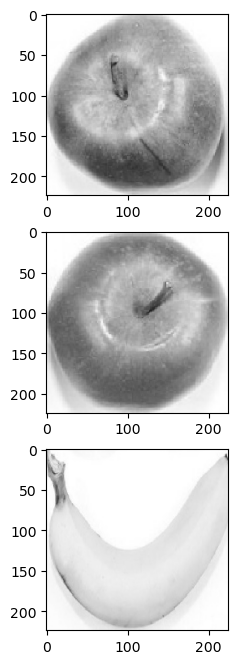

In [53]:
fig=plt.figure(figsize=(8, 8))

rows, cols = count, 1

for j in range(0, cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(img[j])
plt.show()

In [54]:
classes = np.array(train.columns[1:])
for i in range(count):
    proba = model.predict(img[i].reshape(1,224,224,3))
    top_3 = np.argsort(proba[0])[:-6:-1]
    for i in range(5):
        print("{}".format(classes[top_3[i]])+" ({:.5})".format(proba[0][top_3[i]]))

1/1 [==============================] - 2s 2s/step
apple (0.99322)
onion (0.0017252)
orange (0.00081945)
mango (0.00027108)
mushroom (0.00010486)
1/1 [==============================] - 0s 109ms/step
apple (0.59649)
egg (0.017453)
scallop (0.0087912)
mushroom (0.0045257)
coconut (0.0012328)
1/1 [==============================] - 0s 106ms/step
banana (0.99826)
greenbean (0.00066095)
chili (1.7858e-05)
pear (3.7032e-06)
cashew (1.2894e-06)
